<span style="font-size:27px; color:blue">**Multiple Linear Regression**</span>

## Import Necessary Libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.diagnostic import het_breuschpagan

## Exploratory Data Analysis (EDA)

In [6]:
# Loading the data
file_path = "C:\\Users\\Zuu Zuu Kyaw Shwe\\Desktop\\Statistics and Optimisation\\CA\\mlr5.csv"
mlr_data = pd.read_csv(file_path)
mlr_data.head()

,y,x1,x2,x3
0,14923.334339,48.802933,202.174619,C
1,19135.656602,50.371700,195.965649,B
2,15372.800047,52.618043,197.968019,A
3,15626.595082,48.765178,197.876746,B
4,18134.044214,58.961021,199.903762,B


In [8]:
# Check for missing values
missing_values = mlr_data.isnull().sum()
missing_values

y     0
x1    0
x2    0
x3    0
dtype: int64

In [10]:
# Check basic statistics to identify potential outliers
statistics_summary = mlr_data.describe()
statistics_summary

,y,x1,x2
count,1000.000000,1000.000000,1000.000000
mean,15397.667697,49.862441,200.114288
std,1688.386506,4.392076,5.146917
min,7495.862470,24.906049,183.188930
25%,14531.474328,48.044038,196.589304
50%,15414.254950,50.038341,200.157822
75%,16340.051520,51.875176,203.581602
max,23412.846094,67.043130,220.523128


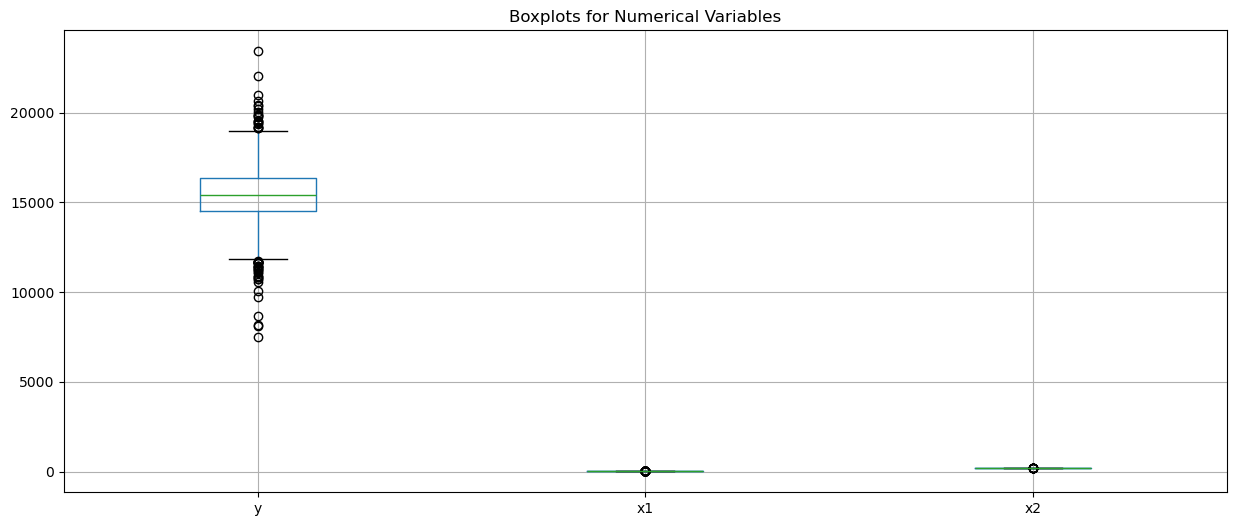

In [12]:
# Outlier detection for numerical variables
plt.figure(figsize=(15, 6))
mlr_data[['y', 'x1', 'x2']].boxplot()
plt.title("Boxplots for Numerical Variables")
plt.show()

In [14]:
# One-hot encode the categorical variable x3
encoded_data = pd.get_dummies(mlr_data, columns=['x3'], drop_first=True)
encoded_data.head()

,y,x1,x2,x3_B,x3_C
0,14923.334339,48.802933,202.174619,False,True
1,19135.656602,50.371700,195.965649,True,False
2,15372.800047,52.618043,197.968019,False,False
3,15626.595082,48.765178,197.876746,True,False
4,18134.044214,58.961021,199.903762,True,False


In [16]:
# Define features and target
X = encoded_data[['x1', 'x2', 'x3_B', 'x3_C']]
y = encoded_data['y']

In [18]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24106585)

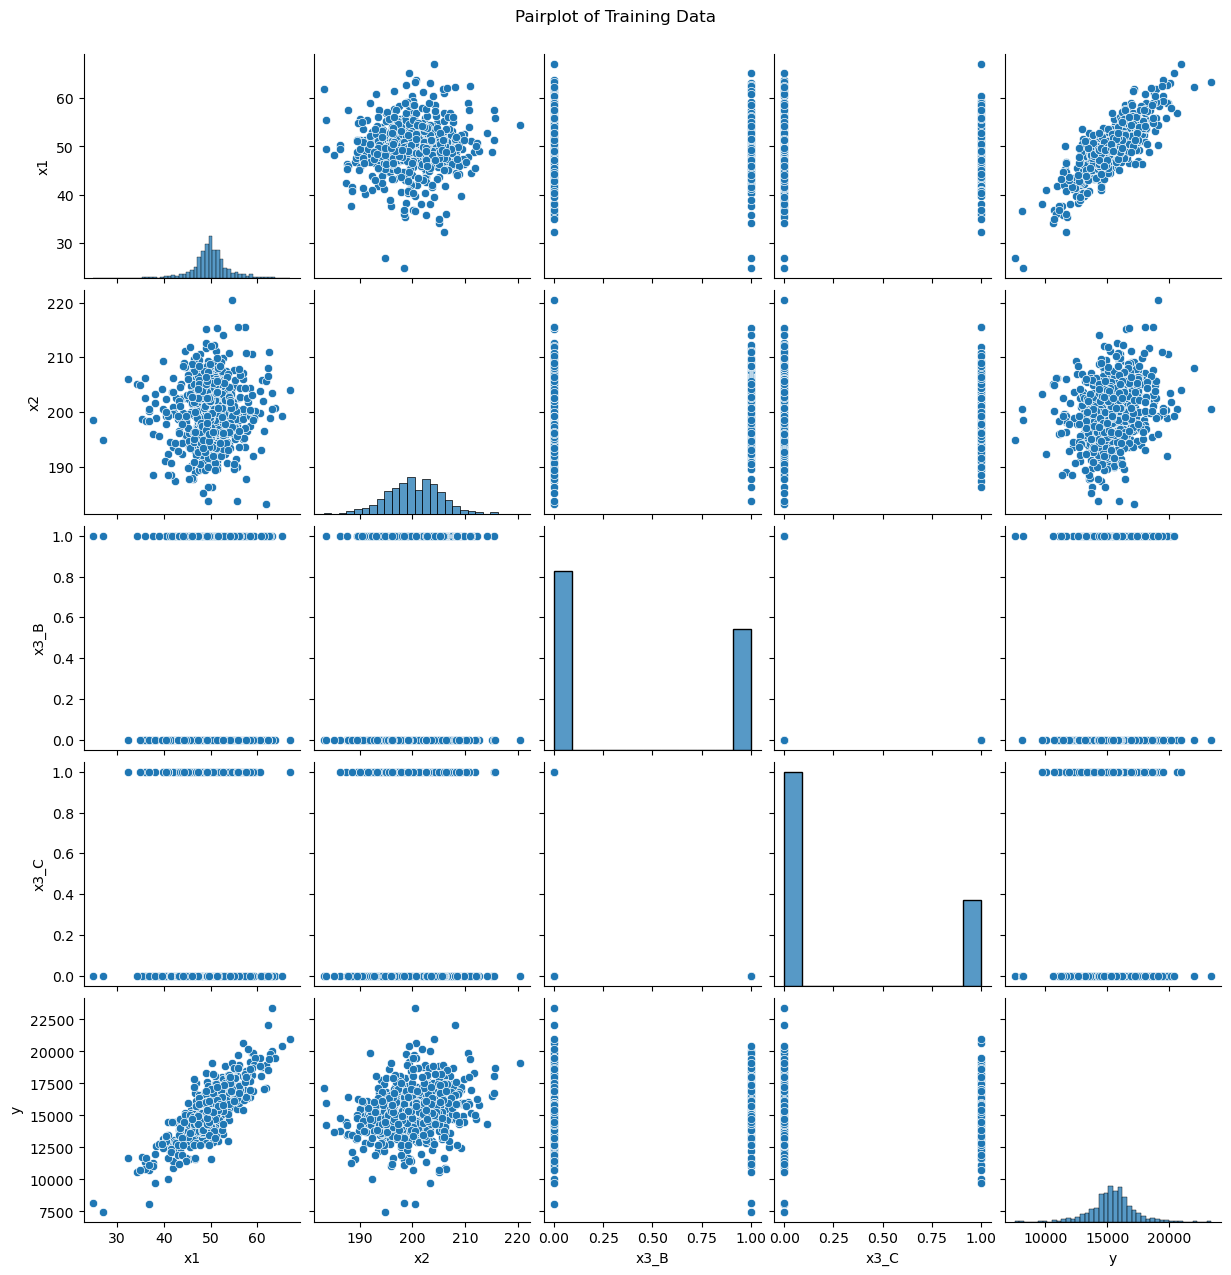

In [20]:
# Pairplot to visualize relationships between numeric variables
sns.pairplot(pd.concat([X_train, y_train], axis=1))
plt.suptitle("Pairplot of Training Data", y=1.02)
plt.show()

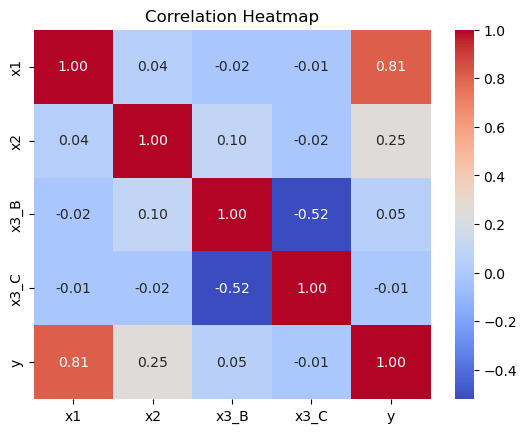

In [22]:
# Correlation heatmap for numeric variables
correlation_matrix = pd.concat([X_train, y_train], axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

## Initial Model Fitting

In [25]:
# Convert boolean columns to integers
X_train['x3_B'] = X_train['x3_B'].astype(int)
X_train['x3_C'] = X_train['x3_C'].astype(int)

# Add a constant for the intercept
X_train_const = sm.add_constant(X_train)

# Fit the multiple linear regression model
mlr_model = sm.OLS(y_train, X_train_const).fit()
mlr_summary = mlr_model.summary()
print(mlr_summary)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     483.2
Date:                Sat, 30 Nov 2024   Prob (F-statistic):          4.09e-211
Time:                        14:22:43   Log-Likelihood:                -6597.9
No. Observations:                 800   AIC:                         1.321e+04
Df Residuals:                     795   BIC:                         1.323e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.447e+04   1315.817    -10.998      0.0

## Regression Diagnostics for for Initial Model

### Variance Inflation Factor (VIF)

In [29]:
vif_data = pd.DataFrame()
vif_data["Predictor"] = X_train_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_const.values, i) 
                           for i in range(X_train_const.shape[1])]
vif_data

,Predictor,VIF
0,const,1612.869340
1,x1,1.002876
2,x2,1.014272
3,x3_B,1.390941
4,x3_C,1.376579


### Residuals vs Fitted Plot

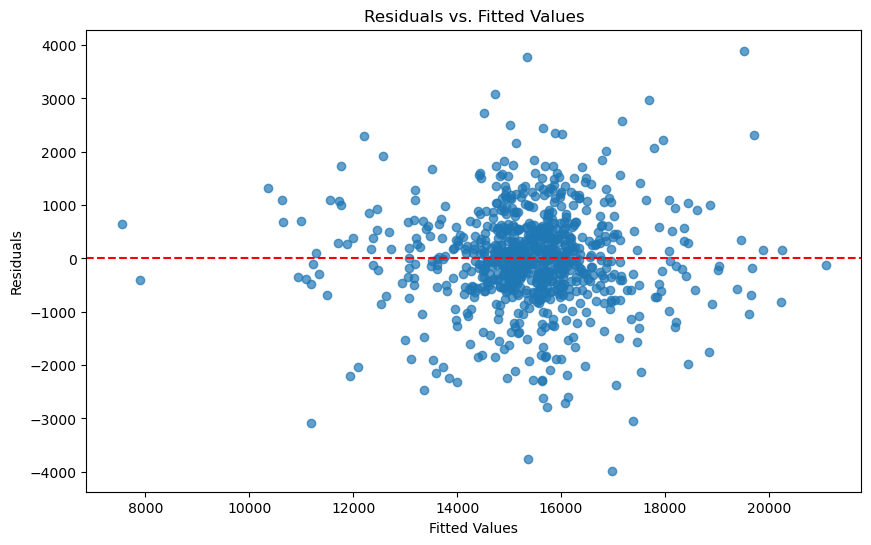

In [32]:
residuals = mlr_model.resid
plt.figure(figsize=(10, 6))
plt.scatter(mlr_model.fittedvalues, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Residuals vs. Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

###  Normal Quantile-Quantile Plot

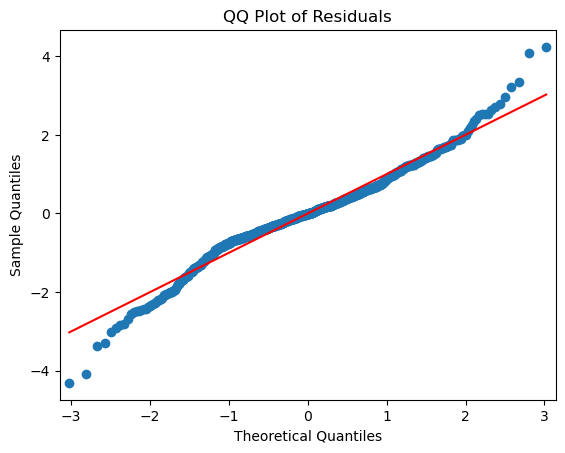

In [35]:
standardized_residuals = mlr_model.get_influence().resid_studentized_internal
sm.qqplot(standardized_residuals, line='s')
plt.title("QQ Plot of Residuals")
plt.show()

### Scale-Location Plot

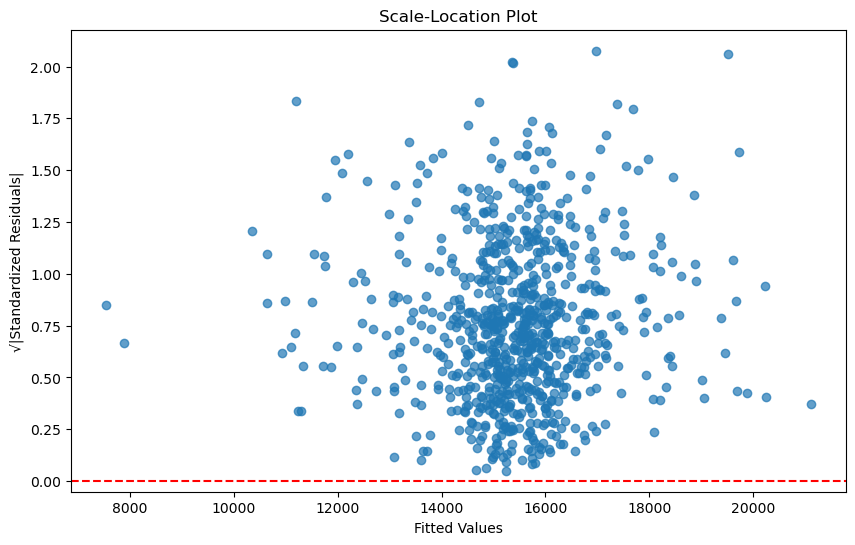

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(mlr_model.fittedvalues, np.sqrt(np.abs(standardized_residuals)), alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Scale-Location Plot")
plt.xlabel("Fitted Values")
plt.ylabel("√|Standardized Residuals|")
plt.show()

### Residuals vs Leverage Plot

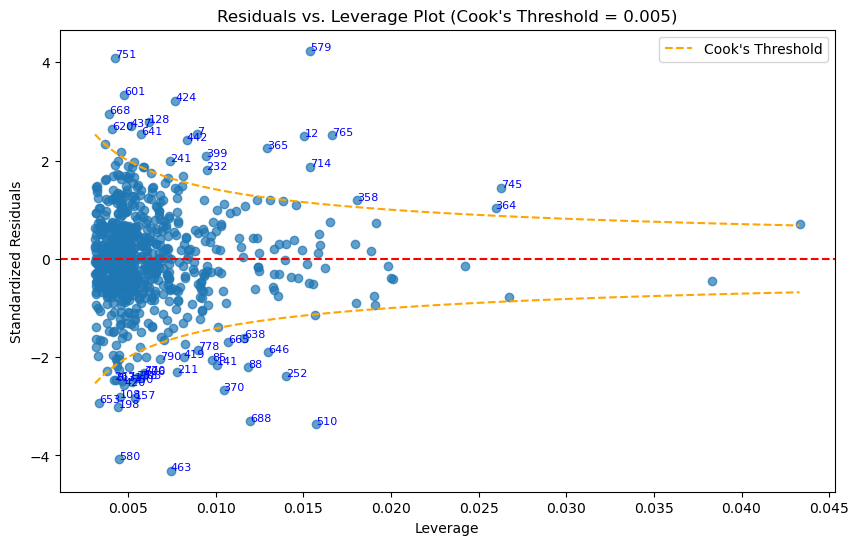

In [41]:
# Extract influence metrics
leverage = mlr_model.get_influence().hat_matrix_diag
cooks_d, _ = mlr_model.get_influence().cooks_distance

# Define thresholds for outlier detection
cooks_threshold = 4 / len(leverage)

# Plot Residuals vs Leverage
plt.figure(figsize=(10, 6))
plt.scatter(leverage, standardized_residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title(f"Residuals vs. Leverage Plot (Cook's Threshold = {cooks_threshold:.3f})")
plt.xlabel("Leverage")
plt.ylabel("Standardized Residuals")

# Add Cook's Distance contours
leverage_range = np.linspace(min(leverage), max(leverage), 100)
cooks_distance_contour = np.sqrt((4 * cooks_threshold) / leverage_range)
plt.plot(leverage_range, cooks_distance_contour, linestyle='--', color='orange', label="Cook's Threshold")
plt.plot(leverage_range, -cooks_distance_contour, linestyle='--', color='orange')

# Mark high-influence points
for i in range(len(leverage)):
    if cooks_d[i] > cooks_threshold:
        plt.text(leverage[i], standardized_residuals[i], str(i), fontsize=8, color="blue")

plt.legend()
plt.show()

## Diagnostic Tests for Initial Model

### Normality - The Shapiro-Wilk test

In [45]:
shapiro_test_stat, shapiro_p_value = shapiro(residuals)
residual_diagnostics = {
    "Shapiro-Wilk Test Statistic": shapiro_test_stat,
    "Shapiro-Wilk P-Value": shapiro_p_value
}
residual_diagnostics

{'Shapiro-Wilk Test Statistic': 0.9715442495100705,
 'Shapiro-Wilk P-Value': 2.253813352867052e-11}

### Homoscedasticity: The Breusch-Pagan Test

In [48]:
bp_test = het_breuschpagan(residuals, X_train_const)
bp_stat, bp_pvalue = bp_test[0], bp_test[1]
print(f"Breusch-Pagan Test Statistic: {bp_stat}, P-value: {bp_pvalue}")

Breusch-Pagan Test Statistic: 5.056405673390074, P-value: 0.2815587339495312


## Test Set Performance for Initial Model

In [51]:
# Add a constant to the test predictors
X_test_const = sm.add_constant(X_test)

# Generate predictions for the test set using the rinitial model
y_test_pred = mlr_model.predict(X_test_const)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2_test = r2_score(y_test, y_test_pred)

# Compile the metrics
test_evaluation_metrics = {
    "Mean Absolute Error (MAE)": mae,
    "Mean Squared Error (MSE)": mse,
    "Root Mean Squared Error (RMSE)": rmse,
    "R-squared (Test)": r2_test
}
test_evaluation_metrics

{'Mean Absolute Error (MAE)': 745.9702609545883,
 'Mean Squared Error (MSE)': 1074709.204139513,
 'Root Mean Squared Error (RMSE)': 1036.681823965055,
 'R-squared (Test)': 0.5740733455510678}

## Identify Influential Observations by Cook's Distance

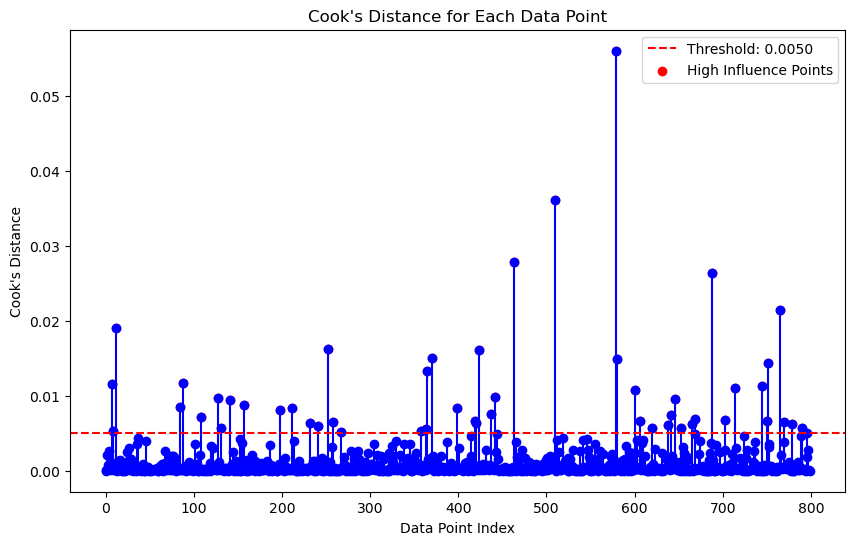

In [54]:
# Plot Cook's Distance
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, linefmt="blue", markerfmt="o", basefmt=" ")

# Threshold line
plt.axhline(y=cooks_threshold, color="red", linestyle="--", linewidth=1.5, label=f"Threshold: {cooks_threshold:.4f}")

# Highlight points exceeding the threshold
high_influence = np.where(cooks_d > cooks_threshold)[0]
plt.scatter(high_influence, cooks_d[high_influence], color="red", label="High Influence Points")

plt.title("Cook's Distance for Each Data Point")
plt.xlabel("Data Point Index")
plt.ylabel("Cook's Distance")
plt.legend()
plt.show()

## Drop Influential Data Points

In [57]:
outliers_df = pd.DataFrame({
    'Leverage': leverage,
    'Cook\'s Distance': cooks_d,
    'Standardized Residuals': standardized_residuals
})

influential_points = outliers_df[outliers_df["Cook's Distance"] > cooks_threshold].index
indices_to_drop = influential_points.intersection(X_train.index)

# Remove these points from the training dataset
X_train_cleaned = X_train.drop(index=indices_to_drop)
y_train_cleaned = y_train.drop(index=indices_to_drop)

# Reset the index for consistency
X_train_cleaned.reset_index(drop=True, inplace=True)
y_train_cleaned.reset_index(drop=True, inplace=True)

print(f"Indices of Excluded Points: {influential_points}")
print(f"Remaining Points in Refitted Model: {len(X_train_cleaned)}")

Indices of Excluded Points: Index([  7,   8,  12,  85,  88, 108, 128, 131, 141, 157, 198, 211, 232, 241,
       252, 258, 267, 358, 364, 365, 370, 399, 419, 420, 424, 437, 442, 463,
       510, 579, 580, 601, 606, 620, 638, 641, 646, 653, 665, 668, 688, 703,
       714, 745, 750, 751, 765, 770, 778, 790],
      dtype='int64')
Remaining Points in Refitted Model: 756


## Refitted Model after Dropping High-Influence Points

In [60]:
X_train_cleaned_const = sm.add_constant(X_train_cleaned)
refit_model = sm.OLS(y_train_cleaned, X_train_cleaned_const).fit()

refit_model_summary = refit_model.summary()

# Display comparison of R-squared & Adj. R-squared between 2 models
original_r2 = mlr_model.rsquared
refit_r2 = refit_model.rsquared

original_adj_r2 = mlr_model.rsquared_adj
refit_adj_r2 = refit_model.rsquared_adj

comparison = {
    "Original R^2": original_r2,
    "Refit R^2": refit_r2,
    "Original Adjusted R^2": original_adj_r2,
    "Refit Adjusted R^2": refit_adj_r2,
}
refit_model_summary, comparison

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.712
 Model:                            OLS   Adj. R-squared:                  0.710
 Method:                 Least Squares   F-statistic:                     463.2
 Date:                Sat, 30 Nov 2024   Prob (F-statistic):          4.64e-201
 Time:                        14:26:14   Log-Likelihood:                -6240.9
 No. Observations:                 756   AIC:                         1.249e+04
 Df Residuals:                     751   BIC:                         1.251e+04
 Df Model:                           4                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

## Regression Diagnostics for Refitted Model

In [65]:
vif_data = pd.DataFrame()
vif_data["Predictor"] = X_train_cleaned_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_cleaned_const.values, i) 
                           for i in range(X_train_cleaned_const.shape[1])]
vif_data

,Predictor,VIF
0,const,1582.557514
1,x1,1.003603
2,x2,1.013837
3,x3_B,1.397937
4,x3_C,1.386122


### Residuals vs Fitted Plot

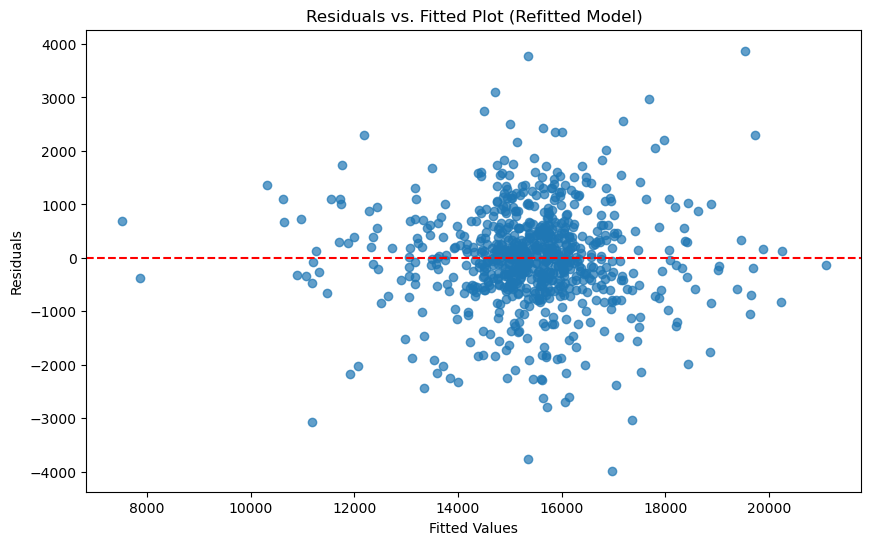

In [68]:
refit_residuals = refit_model.resid
plt.figure(figsize=(10, 6))
plt.scatter(refit_model.fittedvalues, refit_residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Residuals vs. Fitted Plot (Refitted Model)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

### Normal Quantile-Quantile Plot

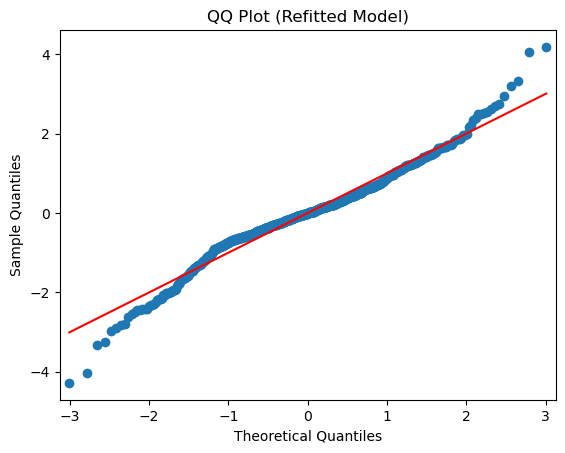

In [71]:
standardized_residuals_refit = refit_model.get_influence().resid_studentized_internal
sm.qqplot(standardized_residuals_refit, line='s')
plt.title("QQ Plot (Refitted Model)")
plt.show()

### Scale-Location Plot

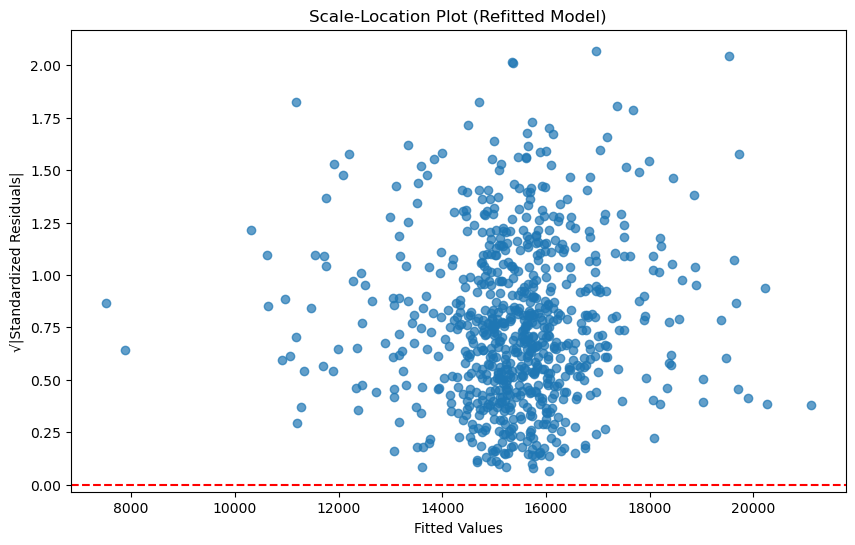

In [74]:
plt.figure(figsize=(10, 6))
plt.scatter(refit_model.fittedvalues, np.sqrt(np.abs(standardized_residuals_refit)), alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Scale-Location Plot (Refitted Model)")
plt.xlabel("Fitted Values")
plt.ylabel("√|Standardized Residuals|")
plt.show()

### Residuals vs Leverage Plot

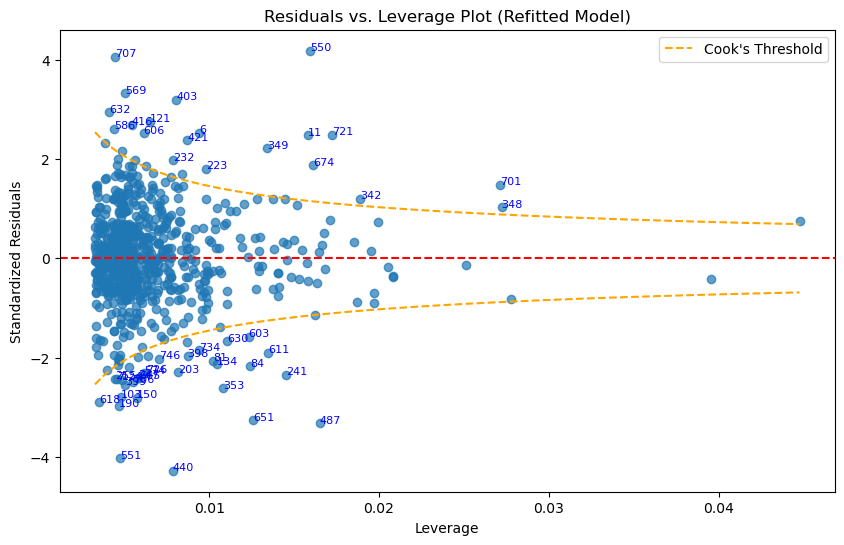

In [82]:
leverage_refit = refit_model.get_influence().hat_matrix_diag
cooks_d_refit, _ = refit_model.get_influence().cooks_distance

cooks_threshold = 4 / len(leverage_refit)

plt.figure(figsize=(10, 6))
plt.scatter(leverage_refit, standardized_residuals_refit, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Residuals vs. Leverage Plot (Refitted Model)")
plt.xlabel("Leverage")
plt.ylabel("Standardized Residuals")

leverage_range = np.linspace(min(leverage_refit), max(leverage_refit), 100)
cooks_distance_contour = np.sqrt((4 * cooks_threshold) / leverage_range)
plt.plot(leverage_range, cooks_distance_contour, linestyle='--', color='orange', label="Cook's Threshold")
plt.plot(leverage_range, -cooks_distance_contour, linestyle='--', color='orange')

for i, (lev, resid, cook) in enumerate(zip(leverage_refit, standardized_residuals_refit, cooks_d_refit)):
    if cook > cooks_threshold:
        plt.text(lev, resid, str(i), fontsize=8, color="blue")

plt.legend()
plt.show()

## Diagnostic Tests for Refitted Model

### Normality - The Shapiro-Wilk test

In [86]:
shapiro_test_stat_refit, shapiro_p_value_refit = shapiro(refit_residuals)
diagnostics_summary = {
    "Shapiro-Wilk Test Statistic (Refit)": shapiro_test_stat_refit,
    "Shapiro-Wilk P-Value (Refit)": shapiro_p_value_refit
}
diagnostics_summary

{'Shapiro-Wilk Test Statistic (Refit)': 0.9705647092951031,
 'Shapiro-Wilk P-Value (Refit)': 3.340734050354777e-11}

### Homoscedasticity: The Breusch-Pagan Test

In [89]:
bp_test = het_breuschpagan(refit_residuals, X_train_cleaned_const)
bp_stat, bp_pvalue = bp_test[0], bp_test[1]
print(f"Breusch-Pagan Test Statistic: {bp_stat}, P-value: {bp_pvalue}")

Breusch-Pagan Test Statistic: 4.950435300426923, P-value: 0.29242105680478286


## Test Set Performance for Refitted Model

In [92]:
X_test_const = sm.add_constant(X_test)
y_test_pred = refit_model.predict(X_test_const)

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2_test = r2_score(y_test, y_test_pred)

test_evaluation_metrics = {
    "Mean Absolute Error (MAE)": mae,
    "Mean Squared Error (MSE)": mse,
    "Root Mean Squared Error (RMSE)": rmse,
    "R-squared (Test)": r2_test
}
test_evaluation_metrics

{'Mean Absolute Error (MAE)': 746.1325884853713,
 'Mean Squared Error (MSE)': 1077450.6293217563,
 'Root Mean Squared Error (RMSE)': 1038.0031933099995,
 'R-squared (Test)': 0.5729868692728359}